# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


<b>Objective:-</b>
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import pickle
from tqdm import tqdm
import os

In [2]:
! pip install gensim

distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
distutils: /home/ubuntu/.local/include/python3.8/UNKNOWN
sysconfig: /home/ubuntu/.local/include/python3.8
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
sample_data = filtered_data.head(50000) #Sampled amazon fine foood reviews filtered data to 50k datapoints for time effiecieny

# Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=sample_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(sample_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [11]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [12]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

2
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [13]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'they', 'did', 'which', 'into', 'wasn', 'under', 'yourselves', "aren't", 'm', 'because', 'by', 'why', 'wouldn', 'y', 'my', 'where', 'do', 'it', 'doing', 'what', 'your', 'above', 'of', 'here', 'both', 'their', 'o', 'ma', 'these', 'how', 'off', 'more', 'didn', 'while', 'between', 'over', 'all', 'some', 'haven', "mustn't", "should've", 'll', 'before', 'themselves', 'ain', 'after', "don't", 'nor', 'ourselves', 'he', 'down', "weren't", 'from', 'through', 'hers', 'for', 'again', 'same', 'am', 'own', "you'd", 'at', 'its', 'me', "you'll", 'be', 'only', 'hadn', 'with', 'few', 'against', 't', "you've", 'up', 'just', 'aren', 'ours', 'we', 'does', 'no', 're', 'myself', 'his', 'weren', 'were', 's', 'other', 'when', 'any', 'isn', 'on', "she's", 'than', "isn't", 'shouldn', 'a', 'too', 'doesn', 'them', 've', 'not', 'won', 'will', 'now', "won't", 'don', "mightn't", "hasn't", 'you', 'is', 'further', 'so', "it's", 'out', "couldn't", 'that', 'should', 'she', 'who', 'an', "needn't", 'had', 'such', 'yours'

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8') #snoball stemmer
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_positive_words, f)      # dump data to f
    with open('negitive_words.pkl', 'wb') as f: # 'wb' instead 'w' for binary file
        pickle.dump(all_negative_words, f)      # dump data to f

In [15]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

### Sorting dataset based on 'Time' feature

In [16]:
final_reviews = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_reviews.shape

(46071, 12)

### Spliting data 

In [17]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final_reviews['CleanedText']
Y = final_reviews['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

In [18]:
print('X_train, Y_train', X_train.shape, Y_train.shape)
print('X_test, Y_test', X_test.shape, Y_test.shape)
print('X_tr, Y_tr', X_tr.shape, Y_tr.shape)
print('X_cv, Y_cv', X_cv.shape, Y_cv.shape)

X_train, Y_train (30867,) (30867,)
X_test, Y_test (15204,) (15204,)
X_tr, Y_tr (20680,) (20680,)
X_cv, Y_cv (10187,) (10187,)


# SVM with SGD Classifier and simple CV

In [19]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

## Training Model

In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
# SVM with penality = 'l1'
def Sgd_Classifier(X_train,X_cv,Y_train,Y_cv):
    best_alpha=0
    max_roc_auc=-1
    pred_cv = []
    pred_train = []
    alpha = [10 ** x for x in range(-5, 3)]
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
        clf.fit(X_train,Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, Y_train)
        probs = sig_clf.predict_proba(X_cv)
        prob = sig_clf.predict_proba(X_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(Y_cv,probs)
        auc_score_train = roc_auc_score(Y_train,prob)
        print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
        if(max_roc_auc<auc_score_cv):
            max_roc_auc=auc_score_cv
            best_alpha=i
    print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
    sns.set_style("darkgrid")
    plt.xscale('log')
    plt.plot(alpha, pred_cv,'r-', label = 'CV Data')
    plt.plot(alpha,pred_train,'g-', label ='Train Data')
    plt.legend(loc='upper right')
    plt.title(r'Auc Score v/s $\alpha$')
    plt.xlabel(r"alpha values",fontsize=12)
    plt.ylabel("roc_auc",fontsize=12)
    plt.show()
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_train,prob)
    # plot no skill
    pyplt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplt.plot(fpr, tpr, marker='.')
    pyplt.title("Line Plot of ROC Curve on Train Data")
    pyplt.ylabel('True Positive Rate')
    pyplt.xlabel('False Positive Rate')
    pyplt.show()    

In [22]:
! pip install scikit-plot

distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 24.9 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 57.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 67.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 71.4 MB/s eta 0:00:01
distutils: /home/ubuntu/.local/include/python3.8/UNKNOWN
sysconfig: /home/ubuntu/.local/include/python3.8
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip'

## Testing Model 

In [23]:

import scikitplot.metrics as skplt
def testing(X_train,Y_train,X_test,Y_test,optimal_alpha):
    clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, Y_train)
    prob = sig_clf.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = prob[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    prediction=np.argmax(prob,axis=1)
    skplt.plot_confusion_matrix(Y_test,prediction)
    print("macro f1 score for data :",metrics.f1_score(Y_test, prediction, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, prediction, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,prediction))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, prediction))

## Top 10 features

In [24]:
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

def imp_feature(vectorizer,classifier, n =10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(classifier.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

# Techniques for vectorization :--

##  Bag of Words (BoW) 

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


In [26]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
bow_train = normalizer.fit_transform(bow_train)
bow_cv = normalizer.transform(bow_cv)
bow_test = normalizer.transform(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


1e-05  for CV data auc score is -->  0.942737479105515  and for train data auc score is -->  0.9818134882363749
0.0001  for CV data auc score is -->  0.9430491013217377  and for train data auc score is -->  0.9584696021788781
0.001  for CV data auc score is -->  0.9344825060744792  and for train data auc score is -->  0.9410639066627072
0.01  for CV data auc score is -->  0.9227647209186105  and for train data auc score is -->  0.9279695662464215
0.1  for CV data auc score is -->  0.6615723853890827  and for train data auc score is -->  0.6539455144547055
1  for CV data auc score is -->  0.6359324110081626  and for train data auc score is -->  0.6269147441453076
10  for CV data auc score is -->  0.6359324110081626  and for train data auc score is -->  0.6269147441453076
100  for CV data auc score is -->  0.6359324110081626  and for train data auc score is -->  0.6269147441453076

 Best C Value 0.0001 with highest roc_auc Score is 0.9430491013217377


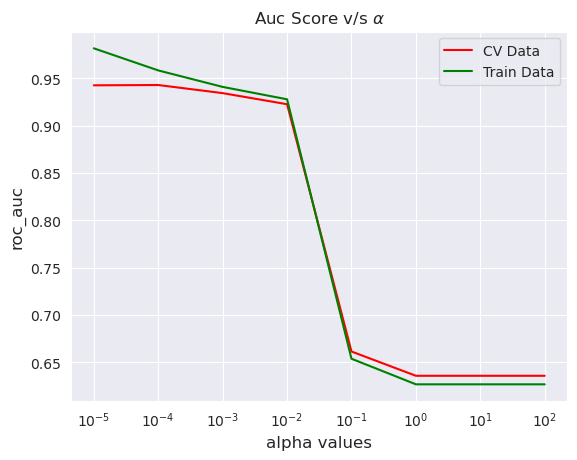

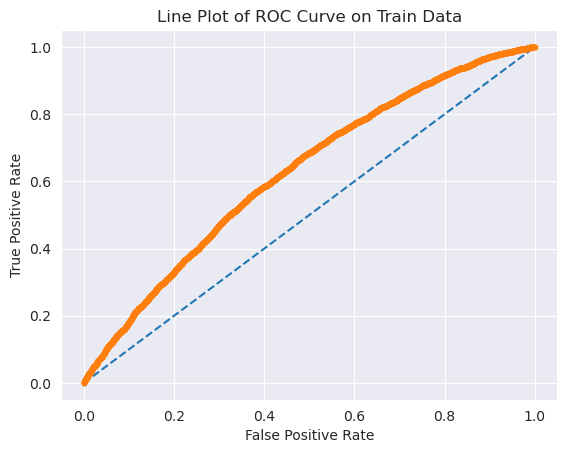

In [27]:
# find optimal alpha using l2 regularization 
Sgd_Classifier(bow_train,bow_cv,Y_tr,Y_cv)

### LR simple CV Over the unseen or Test data in BoW

AUC Score 0.9257807928323164
macro f1 score for data : 0.8068197897150527
micro f1 scoore for data: 0.9043672717705867
hamming loss for data: 0.09563272822941331
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.79      0.58      0.67      2526
           1       0.92      0.97      0.94     12678

    accuracy                           0.90     15204
   macro avg       0.85      0.78      0.81     15204
weighted avg       0.90      0.90      0.90     15204



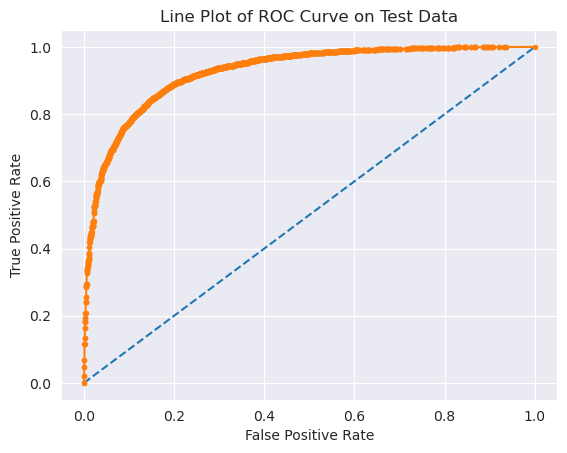

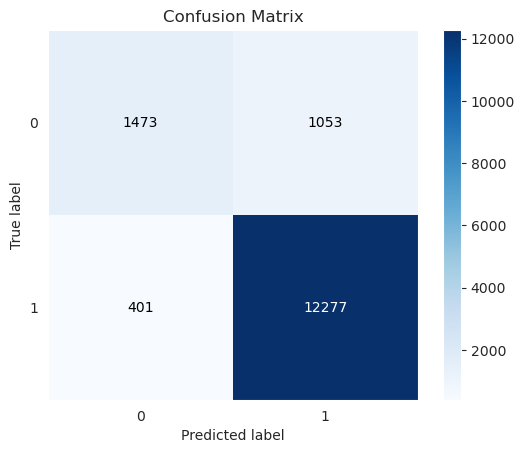

In [28]:
# optimal_C=5 for l1 regularization
testing(bow_train,Y_tr,bow_test,Y_test,optimal_alpha=0.001)

In [29]:
#top 10 important feature for l2 regularization
clf = clf = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', random_state=42)
clf.fit(bow_train,Y_tr)
imp_feature(count_vect,clf)

			Negative						Positive
________________________________________________________________________________________________
	-1.4158	disappoint     				0.7262	great          
	-1.1585	return         				0.6804	best           
	-1.0050	wast           				0.6724	delici         
	-0.8865	aw             				0.5963	love           
	-0.8659	horribl        				0.5563	excel          
	-0.8313	bad            				0.5544	perfect        
	-0.8189	worst          				0.5127	good           
	-0.7527	money          				0.5052	nice           
	-0.7400	terribl        				0.4608	amaz           
	-0.6543	threw          				0.4403	favorit        


##  TF-IDF

In [30]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (20680, 397694)
CV Data Size:  (10187, 397694)
Test Data Size:  (15204, 397694)


In [31]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
bow_train = normalizer.fit_transform(tfidf_train)
bow_cv = normalizer.transform(tfidf_cv)
bow_test = normalizer.transform(tfidf_test)
print("The shape of out text BOW vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text BOW vectorizer  (20680, 397694)
CV Data Size:  (10187, 397694)
Test Data Size:  (15204, 397694)


1e-05  for CV data auc score is -->  0.9551717799516339  and for train data auc score is -->  1.0
0.0001  for CV data auc score is -->  0.9519356478582794  and for train data auc score is -->  0.9971766753105265
0.001  for CV data auc score is -->  0.9485151273199341  and for train data auc score is -->  0.9932913319091566
0.01  for CV data auc score is -->  0.9485324316872403  and for train data auc score is -->  0.9932093981496497
0.1  for CV data auc score is -->  0.6451888114699953  and for train data auc score is -->  0.6613852954605071
1  for CV data auc score is -->  0.6451857957711286  and for train data auc score is -->  0.6613821078358577
10  for CV data auc score is -->  0.6451857957711286  and for train data auc score is -->  0.6613821078358577
100  for CV data auc score is -->  0.6451857957711286  and for train data auc score is -->  0.6613821078358577

 Best C Value 1e-05 with highest roc_auc Score is 0.9551717799516339


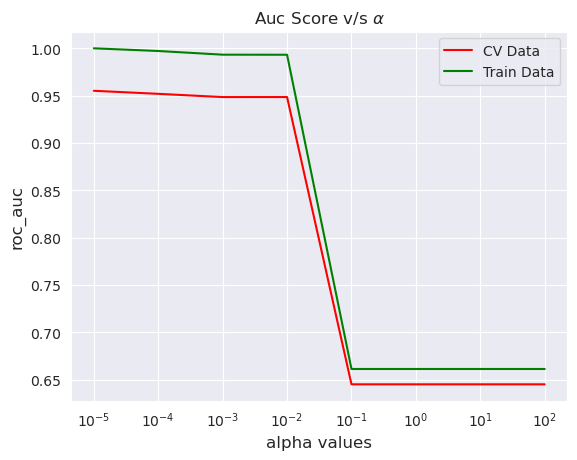

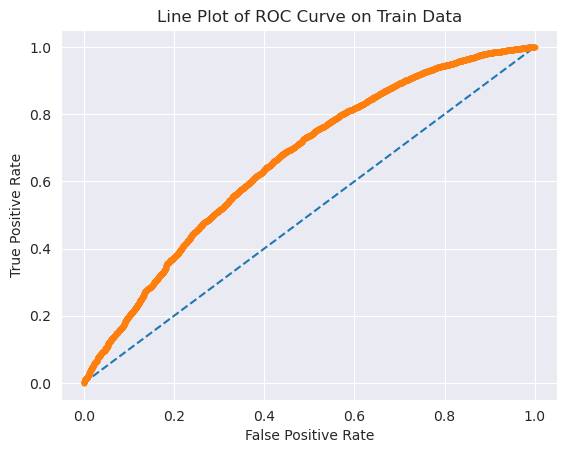

In [32]:
# find optimal_C using l1 regularization
Sgd_Classifier(tfidf_train,tfidf_cv,Y_tr,Y_cv)

### SVM Over the unseen or Test data in TF-IDF

AUC Score 0.9405437433964884
macro f1 score for data : 0.8401129617294885
micro f1 scoore for data: 0.9168639831623258
hamming loss for data: 0.0831360168376743
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.79      0.67      0.73      2526
           1       0.94      0.97      0.95     12678

    accuracy                           0.92     15204
   macro avg       0.87      0.82      0.84     15204
weighted avg       0.91      0.92      0.91     15204



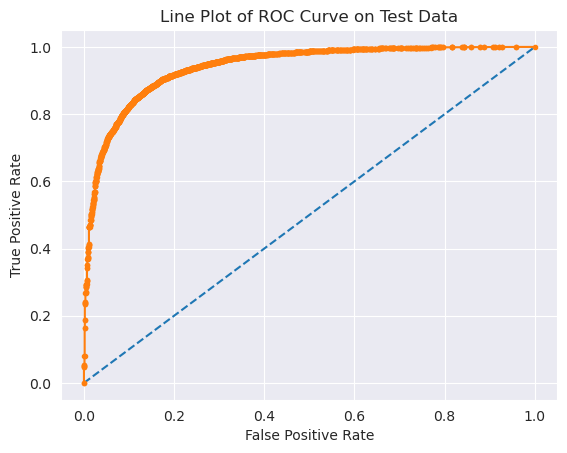

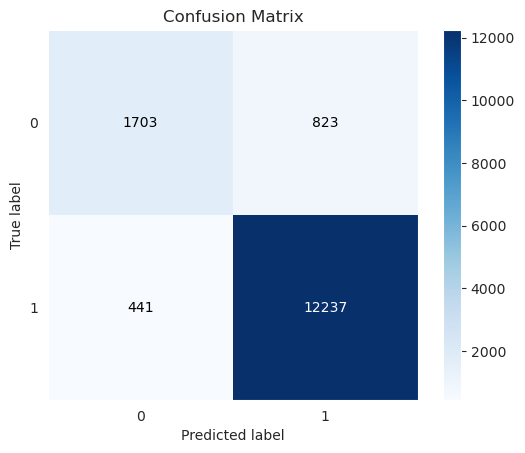

In [33]:
testing(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_alpha=0.001 )

In [34]:
#top 10 important feature for l2 regularization
clf = clf = SGDClassifier(alpha=0.001, penalty='l2', loss='hinge', random_state=42)
clf.fit(tfidf_train,Y_tr)
imp_feature(tf_idf_vect,clf)

			Negative						Positive
________________________________________________________________________________________________
	-0.6784	disappoint     				0.4348	great          
	-0.6295	return         				0.3878	love           
	-0.5082	wast money     				0.3445	best           
	-0.5078	horribl        				0.3383	good           
	-0.5075	aw             				0.3043	delici         
	-0.5075	wast           				0.2610	perfect        
	-0.4982	worst          				0.2520	nice           
	-0.4078	terribl        				0.2276	excel          
	-0.4002	bad            				0.2131	amaz           
	-0.3976	threw          				0.2057	keep           


## Avg W2V

In [35]:
i=0
list_of_sent_train=[]
for sent in X_tr.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [36]:
i=0
list_of_sent_CV=[]
for sent in X_cv.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_CV.append(filtered_sentence)

In [37]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [38]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent_train,min_count=5,vector_size=50,workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

In [39]:
def avg_w2v(list_of_sent):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)        
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [40]:
train_avgw2v = avg_w2v(list_of_sent_train)

20680
50


In [41]:
cv_avgw2v = avg_w2v(list_of_sent_CV)

10187
50


In [42]:
test_avgw2v = avg_w2v(list_of_sent_test)

15204
50


In [43]:
normalizer = preprocessing.Normalizer()
train_avgw2v = normalizer.fit_transform(train_avgw2v)
cv_avgw2v = normalizer.transform(cv_avgw2v)
test_avgw2v = normalizer.transform(test_avgw2v)

1e-05  for CV data auc score is -->  0.8965708631791784  and for train data auc score is -->  0.8896559202057608
0.0001  for CV data auc score is -->  0.8970446151106619  and for train data auc score is -->  0.8889280286469298
0.001  for CV data auc score is -->  0.8940149147849663  and for train data auc score is -->  0.8853684638578769
0.01  for CV data auc score is -->  0.8936743562200943  and for train data auc score is -->  0.8851129647794967
0.1  for CV data auc score is -->  0.8936300541676958  and for train data auc score is -->  0.8849525884684322
1  for CV data auc score is -->  0.8936105957297704  and for train data auc score is -->  0.8849556917643873
10  for CV data auc score is -->  0.8207506648897978  and for train data auc score is -->  0.8153181690439179
100  for CV data auc score is -->  0.5909651816025137  and for train data auc score is -->  0.5884655987584388

 Best C Value 0.0001 with highest roc_auc Score is 0.8970446151106619


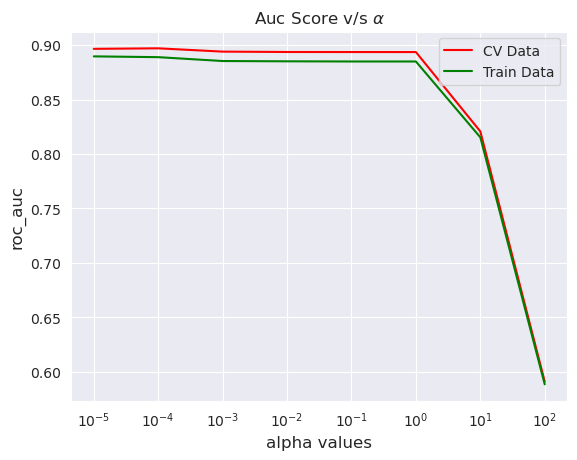

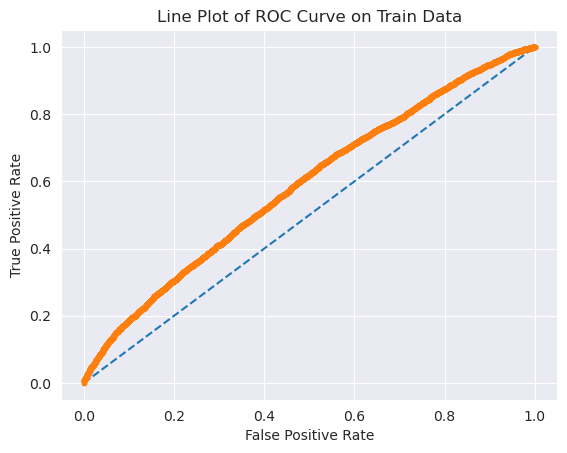

In [44]:
# find optimal_alpha using l2 regularization
Sgd_Classifier(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

AUC Score 0.7998129595759863
macro f1 score for data : 0.4559371273853877
micro f1 scoore for data: 0.8340568271507498
hamming loss for data: 0.1659431728492502
Precision recall report for data:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00      2526
           1       0.83      1.00      0.91     12678

    accuracy                           0.83     15204
   macro avg       0.92      0.50      0.46     15204
weighted avg       0.86      0.83      0.76     15204



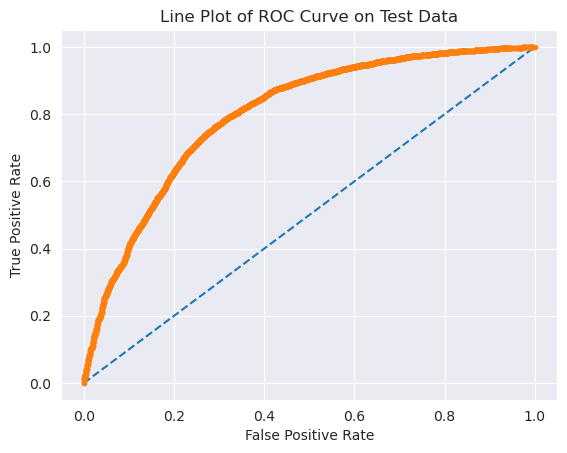

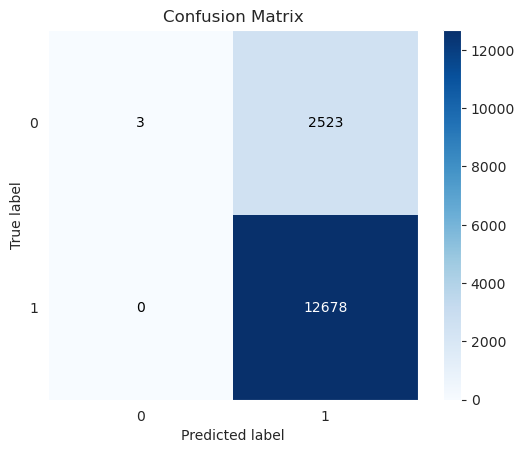

In [45]:
testing(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_alpha=10)

## TF-IDF Weighted W2V

In [46]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (20680, 17391)
CV Data Size:  (10187, 17391)
Test Data Size:  (15204, 17391)


In [47]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))
#return tfidf_sent_vectors_train

20680
50


In [48]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_CV:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
#return tfidf_sent_vectors_CV

10187
50


In [49]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
#return tfidf_sent_vectors_test

15204
50


In [50]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [51]:
normalizer = preprocessing.Normalizer()
train_tfidfw2v = normalizer.fit_transform(train_tfidfw2v)
cv_tfidfw2v = normalizer.transform(cv_tfidfw2v)
test_tfidfw2v = normalizer.transform(test_tfidfw2v)

1e-05  for CV data auc score is -->  0.8721452820109254  and for train data auc score is -->  0.866341245608014
0.0001  for CV data auc score is -->  0.8715145701336673  and for train data auc score is -->  0.8648388793195497
0.001  for CV data auc score is -->  0.867419610084497  and for train data auc score is -->  0.8607917091535712
0.01  for CV data auc score is -->  0.8671517873041951  and for train data auc score is -->  0.8605647300396468
0.1  for CV data auc score is -->  0.8664057608464636  and for train data auc score is -->  0.8598356410133551
1  for CV data auc score is -->  0.866361746003481  and for train data auc score is -->  0.8597824127414315
10  for CV data auc score is -->  0.8141845550264519  and for train data auc score is -->  0.8082237983704963
100  for CV data auc score is -->  0.5786343479484631  and for train data auc score is -->  0.5734755998886119

 Best C Value 1e-05 with highest roc_auc Score is 0.8721452820109254


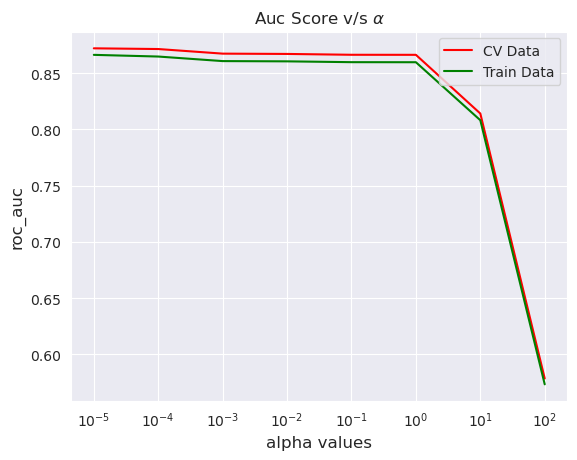

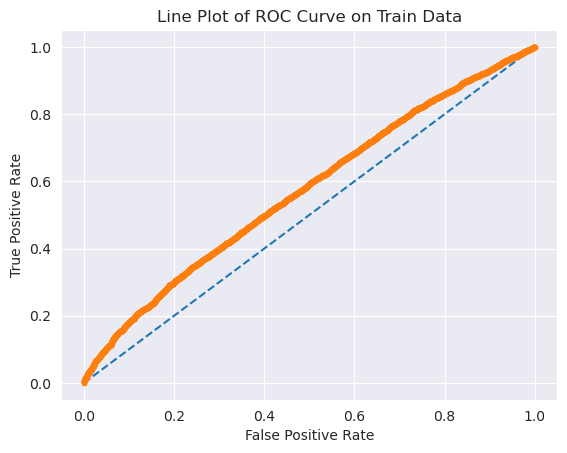

In [52]:
# find optimal_C using l1 regularization
Sgd_Classifier(train_tfidfw2v,cv_tfidfw2v,Y_tr,Y_cv)

AUC Score 0.7954013236313002
macro f1 score for data : 0.4547019582526361
micro f1 scoore for data: 0.8338595106550908
hamming loss for data: 0.16614048934490924
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2526
           1       0.83      1.00      0.91     12678

    accuracy                           0.83     15204
   macro avg       0.42      0.50      0.45     15204
weighted avg       0.70      0.83      0.76     15204



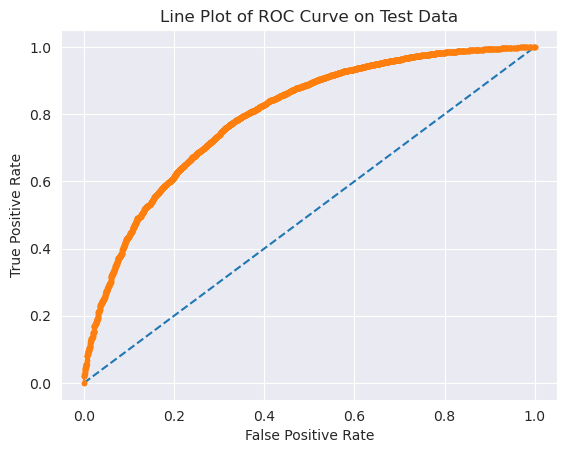

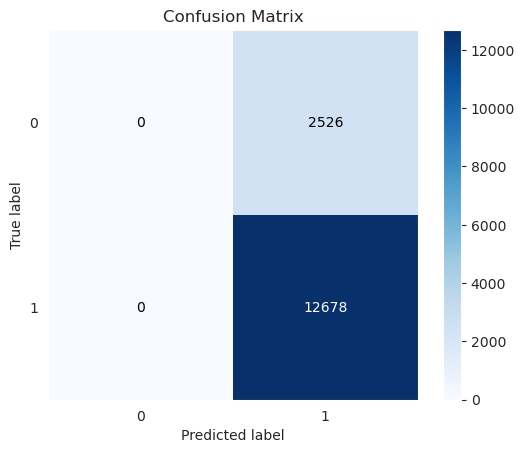

In [53]:
testing(train_tfidfw2v,Y_tr,test_tfidfw2v,Y_test,optimal_alpha=10)

# Kernel SVM 

In [54]:
final_reviews_sample = final_reviews.sample(20000)
final_reviews_sample.shape

(20000, 12)

In [55]:
#split data into train, cross validate and test 
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
X = final_reviews_sample['CleanedText']
Y = final_reviews_sample['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.33, random_state=0)
X_tr, X_cv, Y_tr, Y_cv = train_test_split(X_train, Y_train, test_size=.33, random_state=0)

## Model Training

In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# SVM with kernel = 'rbf'
def SVM_Classifier(X_train,X_cv,Y_train,Y_cv):
    pred_cv = []
    pred_train = []
    C = [10 ** x for x in range(-3, 4)]
    gamma = [10** x for x in range(-4,2)]
    for i in C:
        for j in gamma:
            clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
            clf.fit(X_train,Y_train)
            probs = clf.predict_proba(X_cv)
            prob = clf.predict_proba(X_train)
            probs = probs[:,1]
            prob = prob[:,1]
            auc_score_cv = roc_auc_score(Y_cv,probs)
            auc_score_train = roc_auc_score(Y_train,prob)
            pred_cv.append(auc_score_cv)
            pred_train.append(auc_score_train)
    cmap=sns.light_palette("green")
    # representing heat map for auc score
    print("-"*30, "AUC Score for train data", "-"*30)
    pred_train = np.array(pred_train)
    pred_train = pred_train.reshape(len(C),len(gamma))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.show()
    print("-"*30, "AUC Score for CV data", "-"*30)
    pred_cv = np.array(pred_cv)
    pred_cv = pred_cv.reshape(len(C),len(gamma))
    plt.figure(figsize=(10,5))
    sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.show()

## Model Testing

In [57]:
import scikitplot.metrics as skplt
def testing_SVM(X_train,Y_train,X_test,Y_test,optimal_C,optimal_gamma):
    clf = SVC(C=optimal_C,kernel='rbf',probability=True,gamma=optimal_gamma)
    clf.fit(X_train,Y_train)
    prob = clf.predict_proba(X_test) 
    # keep probabilities for the positive outcome only
    probs = prob[:, 1]
    print("AUC Score",roc_auc_score(Y_test,probs))
    # plot roc curve
    fpr, tpr, thresholds = roc_curve(Y_test,probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("Line Plot of ROC Curve on Test Data")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')    
    plt.show
    predicted =np.argmax(prob,axis=1)
    skplt.plot_confusion_matrix(Y_test,predicted)
    print("macro f1 score for data :",metrics.f1_score(Y_test, predicted, average = 'macro'))
    print("micro f1 scoore for data:",metrics.f1_score(Y_test, predicted, average = 'micro'))
    print("hamming loss for data:",metrics.hamming_loss(Y_test,predicted))
    print("Precision recall report for data:\n",metrics.classification_report(Y_test, predicted))

# Techniques for vectorization :-- 

##  Bag of Words (BoW)  

In [58]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(bow_train))
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])
bow_cv = count_vect.transform(X_cv)
bow_test = count_vect.transform(X_test)
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text BOW vectorizer  (8978, 11854)
CV Data Size:  (4422, 11854)
Test Data Size:  (6600, 11854)


In [59]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
bow_train = normalizer.fit_transform(bow_train)
bow_cv = normalizer.transform(bow_cv)
bow_test = normalizer.transform(bow_test)
print("The shape of out text BOW vectorizer ",bow_train.get_shape())
print("CV Data Size: ",bow_cv.shape)
print("Test Data Size: ",bow_test.shape)

The shape of out text BOW vectorizer  (8978, 11854)
CV Data Size:  (4422, 11854)
Test Data Size:  (6600, 11854)


------------------------------ AUC Score for train data ------------------------------


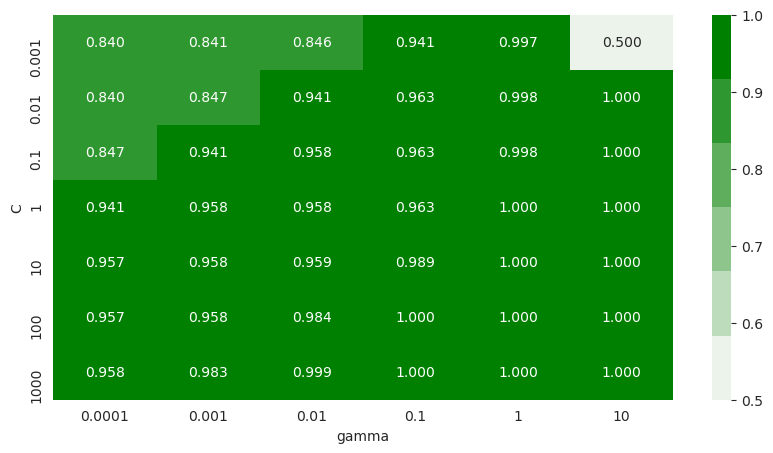

------------------------------ AUC Score for CV data ------------------------------


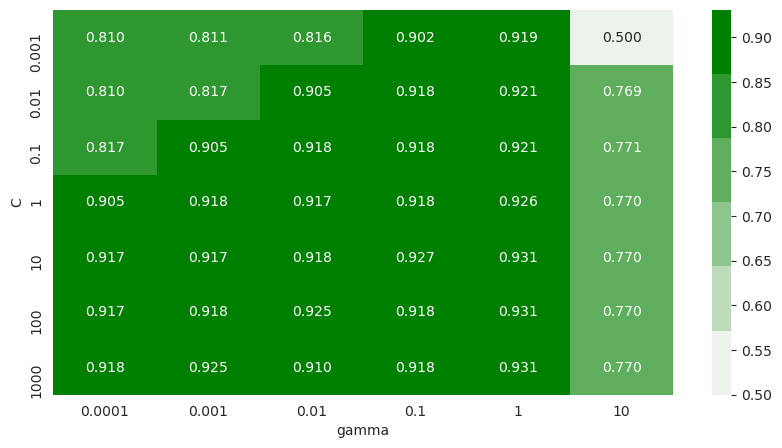

In [60]:
# find optimal C
SVM_Classifier(bow_train,bow_cv,Y_tr,Y_cv)

AUC Score 0.9196159312110909
macro f1 score for data : 0.803393482713749
micro f1 scoore for data: 0.8971212121212121
hamming loss for data: 0.10287878787878788
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.73      0.61      0.67      1113
           1       0.92      0.95      0.94      5487

    accuracy                           0.90      6600
   macro avg       0.83      0.78      0.80      6600
weighted avg       0.89      0.90      0.89      6600



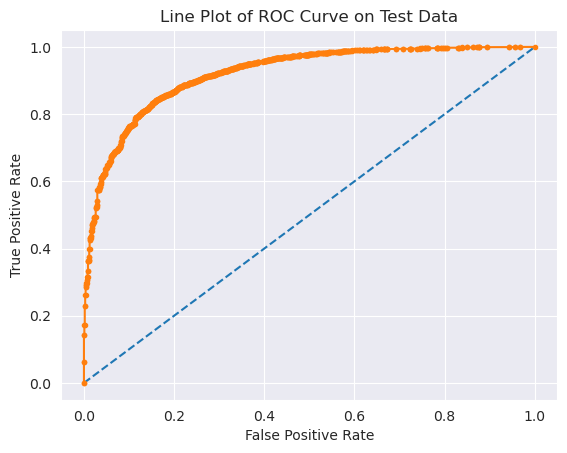

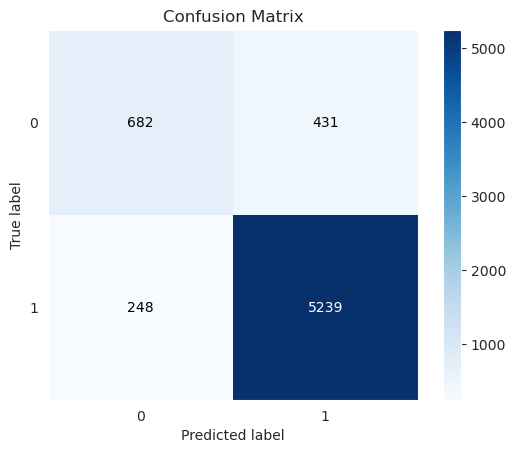

In [61]:
# optimal_C=10
testing_SVM(bow_train,Y_tr,bow_test,Y_test,optimal_C=10,optimal_gamma=0.001)

## TF-IDF 

In [62]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (8978, 209653)
CV Data Size:  (4422, 209653)
Test Data Size:  (6600, 209653)


In [63]:
#Normalize Data
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
normalizer = preprocessing.Normalizer()
tfidf_train = normalizer.fit_transform(tfidf_train)
tfidf_cv = normalizer.transform(tfidf_cv)
tfidf_test = normalizer.transform(tfidf_test)
print("The shape of out text tfidf vectorizer ",tfidf_train.get_shape())
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The shape of out text tfidf vectorizer  (8978, 209653)
CV Data Size:  (4422, 209653)
Test Data Size:  (6600, 209653)


------------------------------ AUC Score for train data ------------------------------


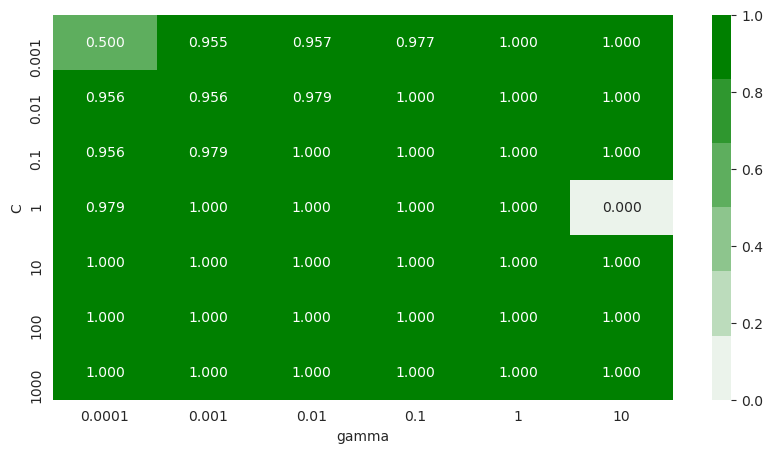

------------------------------ AUC Score for CV data ------------------------------


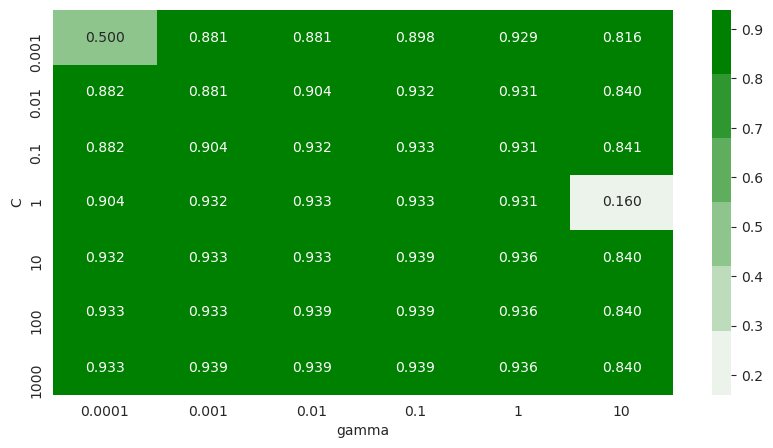

In [64]:
# find optimal_C 
SVM_Classifier(tfidf_train,tfidf_cv,Y_tr,Y_cv)

AUC Score 0.9077459243288597
macro f1 score for data : 0.7846990902058066
micro f1 scoore for data: 0.863939393939394
hamming loss for data: 0.13606060606060605
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.57      0.76      0.65      1113
           1       0.95      0.88      0.92      5487

    accuracy                           0.86      6600
   macro avg       0.76      0.82      0.78      6600
weighted avg       0.89      0.86      0.87      6600



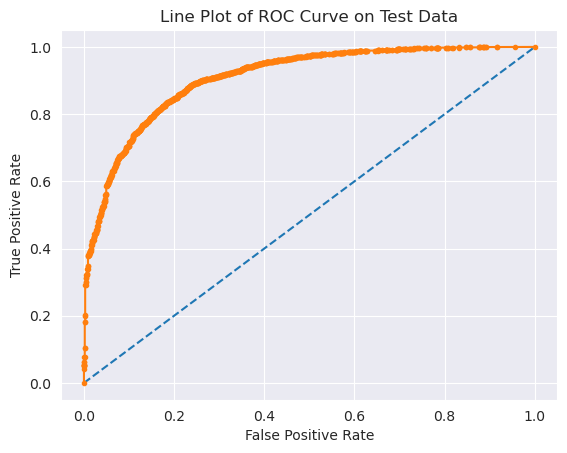

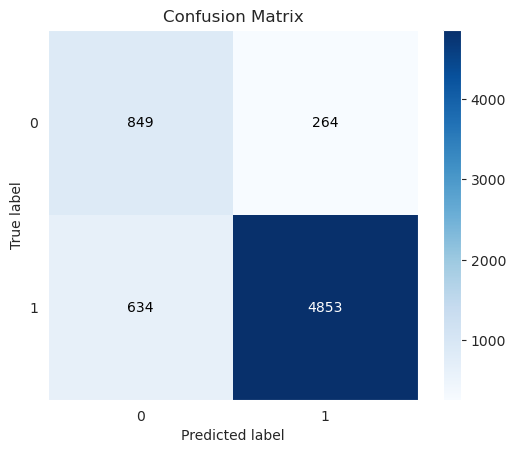

In [65]:
# optimal_C=100
testing_SVM(tfidf_train,Y_tr,tfidf_test,Y_test,optimal_C=0.1,optimal_gamma=0.001)

## Avg W2V

In [66]:
i=0
list_of_sent_train=[]
for sent in X_tr.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [67]:
i=0
list_of_sent_CV=[]
for sent in X_cv.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_CV.append(filtered_sentence)

In [68]:
i=0
list_of_sent_test=[]
for sent in X_test.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [71]:
import gensim
w2v_model = gensim.models.Word2Vec(list_of_sent_train,min_count=5,vector_size=50,workers=4)
w2v_words = list(w2v_model.wv.index_to_key)

In [72]:
train_avgw2v = avg_w2v(list_of_sent_train)

8978
50


In [73]:
cv_avgw2v = avg_w2v(list_of_sent_CV)

4422
50


In [74]:
test_avgw2v = avg_w2v(list_of_sent_test)

6600
50


In [75]:
normalizer = preprocessing.Normalizer()
train_avgw2v = normalizer.fit_transform(train_avgw2v)
cv_avgw2v = normalizer.transform(cv_avgw2v)
test_avgw2v = normalizer.transform(test_avgw2v)

------------------------------ AUC Score for train data ------------------------------


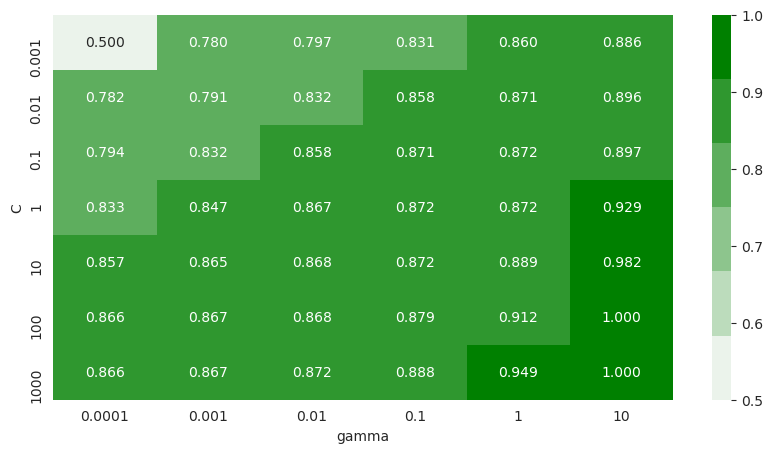

------------------------------ AUC Score for CV data ------------------------------


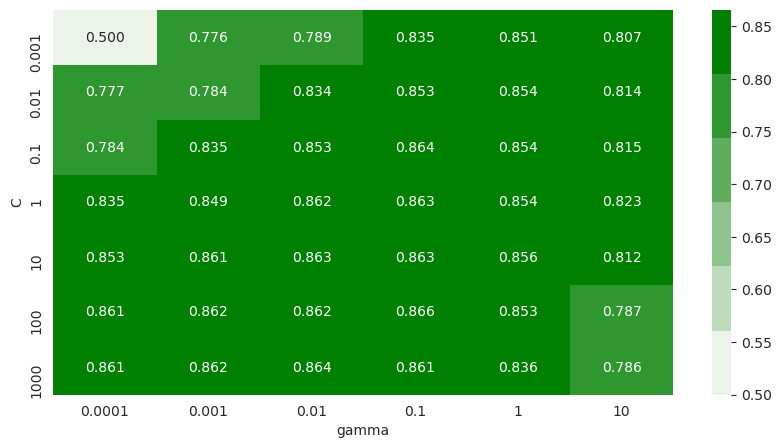

In [76]:
# find optimal_C
SVM_Classifier(train_avgw2v,cv_avgw2v,Y_tr,Y_cv)

AUC Score 0.8547246608048985
macro f1 score for data : 0.6939348891894617
micro f1 scoore for data: 0.8603030303030303
hamming loss for data: 0.1396969696969697
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.65      0.36      0.47      1113
           1       0.88      0.96      0.92      5487

    accuracy                           0.86      6600
   macro avg       0.77      0.66      0.69      6600
weighted avg       0.84      0.86      0.84      6600



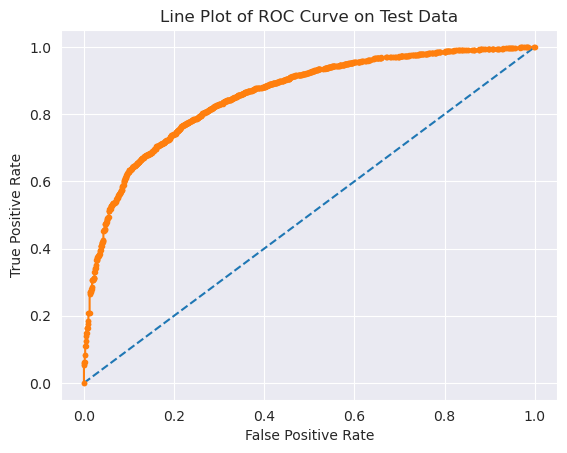

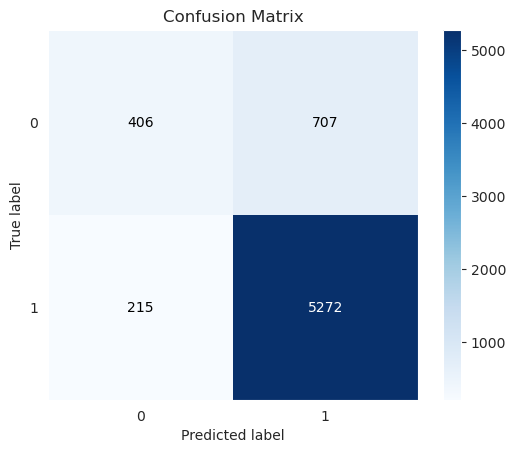

In [77]:
testing_SVM(train_avgw2v,Y_tr,test_avgw2v,Y_test,optimal_C=10,optimal_gamma=0.1)

## TF-IDF Weighted W2V 

In [78]:
tf_idf_vect = TfidfVectorizer()
tfidf_train = tf_idf_vect.fit_transform(X_tr)
print("The type of count vectorizer ",type(tfidf_train))
print("The shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
tfidf_cv = tf_idf_vect.transform(X_cv)
tfidf_test = tf_idf_vect.transform(X_test)
print("CV Data Size: ",tfidf_cv.shape)
print("Test Data Size: ",tfidf_test.shape)

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of out text TFIDF vectorizer  (8978, 11854)
CV Data Size:  (4422, 11854)
Test Data Size:  (6600, 11854)


In [79]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_train[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))
#return tfidf_sent_vectors_train

8978
50


In [80]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_CV = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_CV:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_cv[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_CV.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_CV))
print(len(tfidf_sent_vectors_CV[0]))
#return tfidf_sent_vectors_CV

4422
50


In [81]:
t = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tfidf = tfidf_test[row,t.index(word)]
            sent_vec += (vec * tfidf)
            cnt_words += tfidf
    if cnt_words != 0:
        sent_vec /= cnt_words
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))
#return tfidf_sent_vectors_test

6600
50


In [82]:
train_tfidfw2v = tfidf_sent_vectors_train
cv_tfidfw2v = tfidf_sent_vectors_CV
test_tfidfw2v = tfidf_sent_vectors_test

In [83]:
normalizer = preprocessing.Normalizer()
train_tfidfw2v = normalizer.fit_transform(train_tfidfw2v)
cv_tfidfw2v = normalizer.transform(cv_tfidfw2v)
test_tfidfw2v = normalizer.transform(test_tfidfw2v)

------------------------------ AUC Score for train data ------------------------------


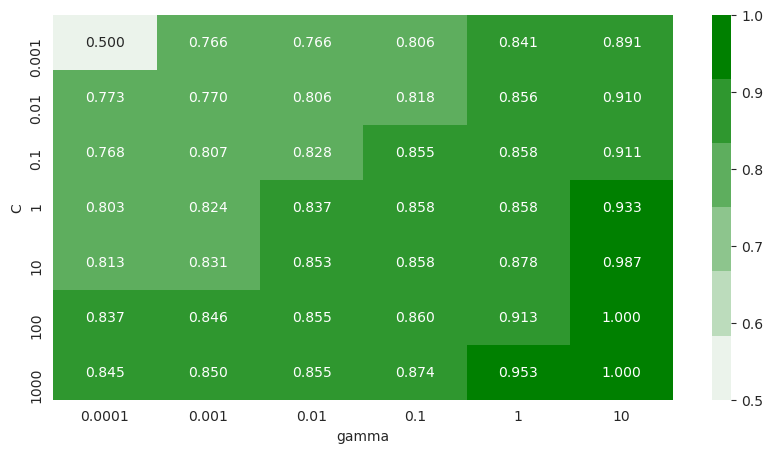

------------------------------ AUC Score for CV data ------------------------------


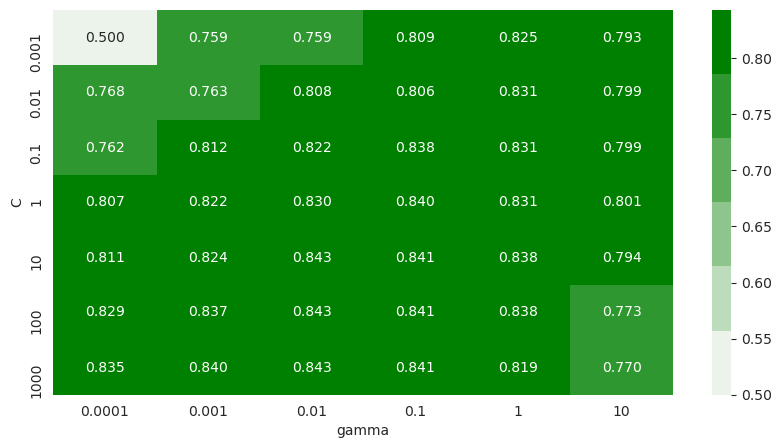

In [84]:
# find optimal_C using l1 regularization
SVM_Classifier(train_tfidfw2v,cv_tfidfw2v,Y_tr,Y_cv)

AUC Score 0.8382228614853928
macro f1 score for data : 0.6368259545307995
micro f1 scoore for data: 0.8525757575757577
hamming loss for data: 0.14742424242424243
Precision recall report for data:
               precision    recall  f1-score   support

           0       0.68      0.24      0.36      1113
           1       0.86      0.98      0.92      5487

    accuracy                           0.85      6600
   macro avg       0.77      0.61      0.64      6600
weighted avg       0.83      0.85      0.82      6600



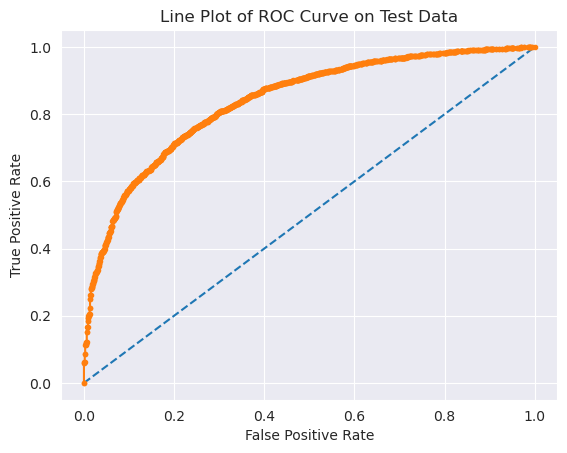

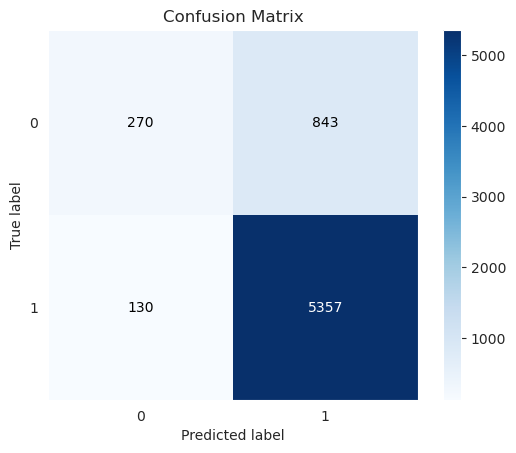

In [85]:
testing_SVM(train_tfidfw2v,Y_tr,test_tfidfw2v,Y_test,optimal_C=100,optimal_gamma=0.01)

In [88]:
# !pip install prettytable
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best Hyper Parameter(C)","Test Auc Score"]
x.add_row(["BoW","Liner kernel",0.001,92.36])
x.add_row(["Tf-Idf","Liner kernel",0.001,94.08])
x.add_row(["Avg-W2V","Liner kernel",10,88.46])
x.add_row(["TfIdf-W2V","Liner kernel",10,86.24])

y = PrettyTable()
y.field_names = ["Vectorizer", "Model", "Best Hyper Parameter(C & gamma)","Test Auc Score"]
y.add_row(["BoW","RBF kernel",(10,0.001),91.41])
y.add_row(["Tf-Idf","RBF kernel",(0.1,0.001),91.51])
y.add_row(["Avg-W2V","RBF kernel",(10,0.1),85.32])
y.add_row(["TfIdf-W2V","RBF kernel",(100,0.01),82.89])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)
print(y)

****Final Conclusion:****

+------------+--------------+-------------------------+----------------+
| Vectorizer |    Model     | Best Hyper Parameter(C) | Test Auc Score |
+------------+--------------+-------------------------+----------------+
|    BoW     | Liner kernel |          0.001          |     92.36      |
|   Tf-Idf   | Liner kernel |          0.001          |     94.08      |
|  Avg-W2V   | Liner kernel |            10           |     88.46      |
| TfIdf-W2V  | Liner kernel |            10           |     86.24      |
+------------+--------------+-------------------------+----------------+
+------------+------------+---------------------------------+----------------+
| Vectorizer |   Model    | Best Hyper Parameter(C & gamma) | Test Auc Score |
+------------+------------+---------------------------------+----------------+
|    BoW     | RBF kernel |           (10, 0.001)           |     91.41      |
|   Tf-Idf   | RBF kernel |           (0.1, 0.001)          |     91.51      |
|  Avg-W2V   | RBF ke